In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pickle

In [2]:
# reading input data 

with open('../datasets/question_titles_vec.pickle', 'rb') as f:
    X_t = pickle.load(f)
    
with open('../datasets/questions_vec.pickle', 'rb') as f:
    X_q = pickle.load(f)
    
with open('../datasets/answers_vec.pickle', 'rb') as f:
    X_a = pickle.load(f)

In [3]:
X_t.shape, X_q.shape, X_a.shape

((6076, 32, 300), (6076, 500, 300), (6076, 500, 300))

In [4]:
data = pd.read_pickle('../datasets/train_processed.pickle')

In [5]:
target_names = data.columns[3:-3].copy()

y = data[data.columns[3:-3]].values.copy()
y.shape

(6076, 30)

In [6]:
# train test split
from sklearn.model_selection import train_test_split

X_t_train, X_t_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2, random_state=42)
X_q_train, X_q_test, y_train, y_test = train_test_split(X_q, y, test_size=0.2, random_state=42)
X_a_train, X_a_test, y_train, y_test = train_test_split(X_a, y, test_size=0.2, random_state=42)

In [7]:
X_q_train.shape

(4860, 500, 300)

# Utility functions

In [8]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error as mse

def print_cors_mse(target_names, preds, reals):
    cors = []
    mses = []
    for i in range(len(target_names)):
        name = target_names[i]
        name = name + ':'
        if len(name)<40:
            name = name + ' '*(40-len(name))
        print(name, f'cor: {np.round(spearmanr(preds[:,i],reals[:,i]).correlation,3)},    mse: {np.round(mse(preds[:,i],reals[:,i]),3)}')
        cors.append(spearmanr(preds[:,i],reals[:,i]).correlation)
        mses.append(mse(preds[:,i],reals[:,i]))
    print('\n\n CORRELATION STATS: \n', pd.Series(cors).describe())
    print('\n\n MSE STATS: \n', pd.Series(mses).describe())

In [9]:
def plot_cors_mse(target_names, preds, reals):
    cors = []
    mses = []
    for i in range(len(target_names)):
        cors.append(spearmanr(preds[:,i],reals[:,i]).correlation)
        mses.append(mse(preds[:,i],reals[:,i]))
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.bar(target_names, cors)
    plt.xticks(rotation=90)
    plt.title('CORS')
    plt.subplot(1,2,2)
    plt.bar(target_names, mses)
    plt.xticks(rotation=90)
    plt.title('MSEs')

In [10]:
# scatterplots

def scatterplots(target_names, preds, reals):
    plt.figure(figsize=(25,35))
    for i in range(len(target_names)):
        plt.subplot(10,3,i+1)
        plt.scatter(preds[:,i],reals[:,i])
        plt.title(target_names[i])
        plt.tight_layout()
    plt.show()

In [11]:
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=10, restore_best_weights=True)

In [12]:
import tensorflow.keras.backend as K

class attention_many_to_one(keras.layers.Layer):

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        #super().build(input_shape)

    def call(self,x):
        # like time-distributed dense
        # each time point has 64 features
        # takes dot of features with weights (weights have dim 64)
        # returns vector of len 30 - for each timepoint, just one value is returned
        # squeezed from (30,1) to 30
        dots=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        softmax_weights=K.softmax(dots)
        softmax_weights=K.expand_dims(softmax_weights,axis=-1)
        # each time point is miltiplied by corresponding scalar
        # this gives greater weight to more important words in output sequence
        output=x*softmax_weights
        # all 30 time ponts are summed to get just one vector of dim 64
        return K.sum(output,axis=1)

# Model

In [13]:
# titles
input_t = keras.layers.Input(shape=(32,300))
x_t = keras.layers.Attention()([input_t,input_t])
x_t = keras.layers.BatchNormalization()(x_t)
x_t = keras.layers.Masking()(x_t)
x_t = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_t)
#x_t = keras.layers.BatchNormalization()(x_t)
x_t = attention_many_to_one()(x_t)
x_t = keras.layers.BatchNormalization()(x_t)
x_t = keras.layers.Dropout(0.3)(x_t)
x_t = keras.layers.Dense(30, activity_regularizer='l2', activation=keras.activations.swish)(x_t)

# questions
input_q = keras.layers.Input(shape=(500,300))
x_q = keras.layers.Attention()([input_q,input_q])
x_q = keras.layers.BatchNormalization()(x_q)
x_q = keras.layers.Masking()(x_q)
x_q = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_q)
#x_q = keras.layers.BatchNormalization()(x_q)
x_q_1 = attention_many_to_one()(x_q)
x_q_1 = keras.layers.BatchNormalization()(x_q_1)
x_q_1 = keras.layers.Dropout(0.3)(x_q_1)
x_q_1 = keras.layers.Dense(100, activity_regularizer='l2', activation=keras.activations.swish)(x_q_1)

# answers
input_a = keras.layers.Input(shape=(500,300))
x_a = keras.layers.Attention()([input_a,input_a])
x_a = keras.layers.BatchNormalization()(x_a)
x_a = keras.layers.Masking()(x_a)
x_a = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_a)
#x_a = keras.layers.BatchNormalization()(x_a)
x_a_1 = attention_many_to_one()(x_a)
x_a_1 = keras.layers.BatchNormalization()(x_a_1)
x_a_1 = keras.layers.Dropout(0.3)(x_a_1)
x_a_1 = keras.layers.Dense(100, activity_regularizer='l2', activation=keras.activations.swish)(x_a_1)

# questions-answers
x_q_a = keras.layers.Attention()([x_q,x_a])
x_q_a = keras.layers.Masking()(x_q_a)
x_q_a = keras.layers.BatchNormalization()(x_q_a)
x_q_a = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_q_a)
#x_q_a = keras.layers.BatchNormalization()(x_q_a)
x_q_a = attention_many_to_one()(x_q_a)
x_q_a = keras.layers.BatchNormalization()(x_q_a)
x_q_a = keras.layers.Dropout(0.3)(x_q_a)
x_q_a = keras.layers.Dense(100, activity_regularizer='l2', activation=keras.activations.swish)(x_q_a)

x = keras.layers.concatenate((x_t, x_q_1, x_a_1, x_q_a))

x = keras.layers.BatchNormalization(name='last_batch_normalization')(x)

output = keras.layers.Dense(30, activation='sigmoid')(x)

model = keras.Model([input_t, input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
attention_1 (Attention)         (None, 500, 300)     0           input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
attention_2 (Attention)         (None, 500, 300)     0           input_3[0][0]         

In [18]:
model.fit([X_t_train, X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_t_test, X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 39s 1s/step - loss: 0.0466 - val_loss: 0.0494
Epoch 2/500
34/34 [==============================] - 33s 967ms/step - loss: 0.0402 - val_loss: 0.0499
Epoch 3/500
34/34 [==============================] - 33s 970ms/step - loss: 0.0388 - val_loss: 0.0469
Epoch 4/500
34/34 [==============================] - 33s 969ms/step - loss: 0.0389 - val_loss: 0.0474
Epoch 5/500
34/34 [==============================] - 33s 969ms/step - loss: 0.0380 - val_loss: 0.0502
Epoch 6/500
34/34 [==============================] - 33s 970ms/step - loss: 0.0378 - val_loss: 0.0479
Epoch 7/500
34/34 [==============================] - 33s 970ms/step - loss: 0.0372 - val_loss: 0.0469
Epoch 8/500
34/34 [==============================] - 33s 973ms/step - loss: 0.0367 - val_loss: 0.0481
Epoch 9/500
34/34 [==============================] - 33s 974ms/step - loss: 0.0366 - val_loss: 0.0474
Epoch 10/500
34/34 [==============================] - 34s 987ms/step - loss: 0.0363 -

In [19]:
model.save_weights('models/final_model_weights_no_norm_2.h5')

In [20]:
model.load_weights('models/final_model_weights_no_norm.h5')

In [21]:
preds_train = model.predict([X_t_train, X_q_train, X_a_train])
preds_test = model.predict([X_t_test, X_q_test, X_a_test])

In [24]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.319,    mse: 0.016
question_body_critical:                  cor: 0.578,    mse: 0.033
question_conversational:                 cor: 0.404,    mse: 0.027
question_expect_short_answer:            cor: 0.19,    mse: 0.123
question_fact_seeking:                   cor: 0.287,    mse: 0.079
question_has_commonly_accepted_answer:   cor: 0.37,    mse: 0.088
question_interestingness_others:         cor: 0.37,    mse: 0.017
question_interestingness_self:           cor: 0.439,    mse: 0.028
question_multi_intent:                   cor: 0.432,    mse: 0.094
question_not_really_a_question:          cor: -0.008,    mse: 0.002
question_opinion_seeking:                cor: 0.392,    mse: 0.115
question_type_choice:                    cor: 0.507,    mse: 0.1
question_type_compare:                   cor: 0.335,    mse: 0.022
question_type_consequence:               cor: 0.067,    mse: 0.005
question_type_definition:                cor: 0.33,    mse: 0.013


In [25]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.426,    mse: 0.015
question_body_critical:                  cor: 0.719,    mse: 0.024
question_conversational:                 cor: 0.434,    mse: 0.017
question_expect_short_answer:            cor: 0.485,    mse: 0.093
question_fact_seeking:                   cor: 0.577,    mse: 0.055
question_has_commonly_accepted_answer:   cor: 0.552,    mse: 0.059
question_interestingness_others:         cor: 0.42,    mse: 0.015
question_interestingness_self:           cor: 0.567,    mse: 0.023
question_multi_intent:                   cor: 0.635,    mse: 0.06
question_not_really_a_question:          cor: 0.003,    mse: 0.002
question_opinion_seeking:                cor: 0.66,    mse: 0.077
question_type_choice:                    cor: 0.678,    mse: 0.064
question_type_compare:                   cor: 0.312,    mse: 0.011
question_type_consequence:               cor: 0.146,    mse: 0.006
question_type_definition:                cor: 0.345,    mse: 0.00

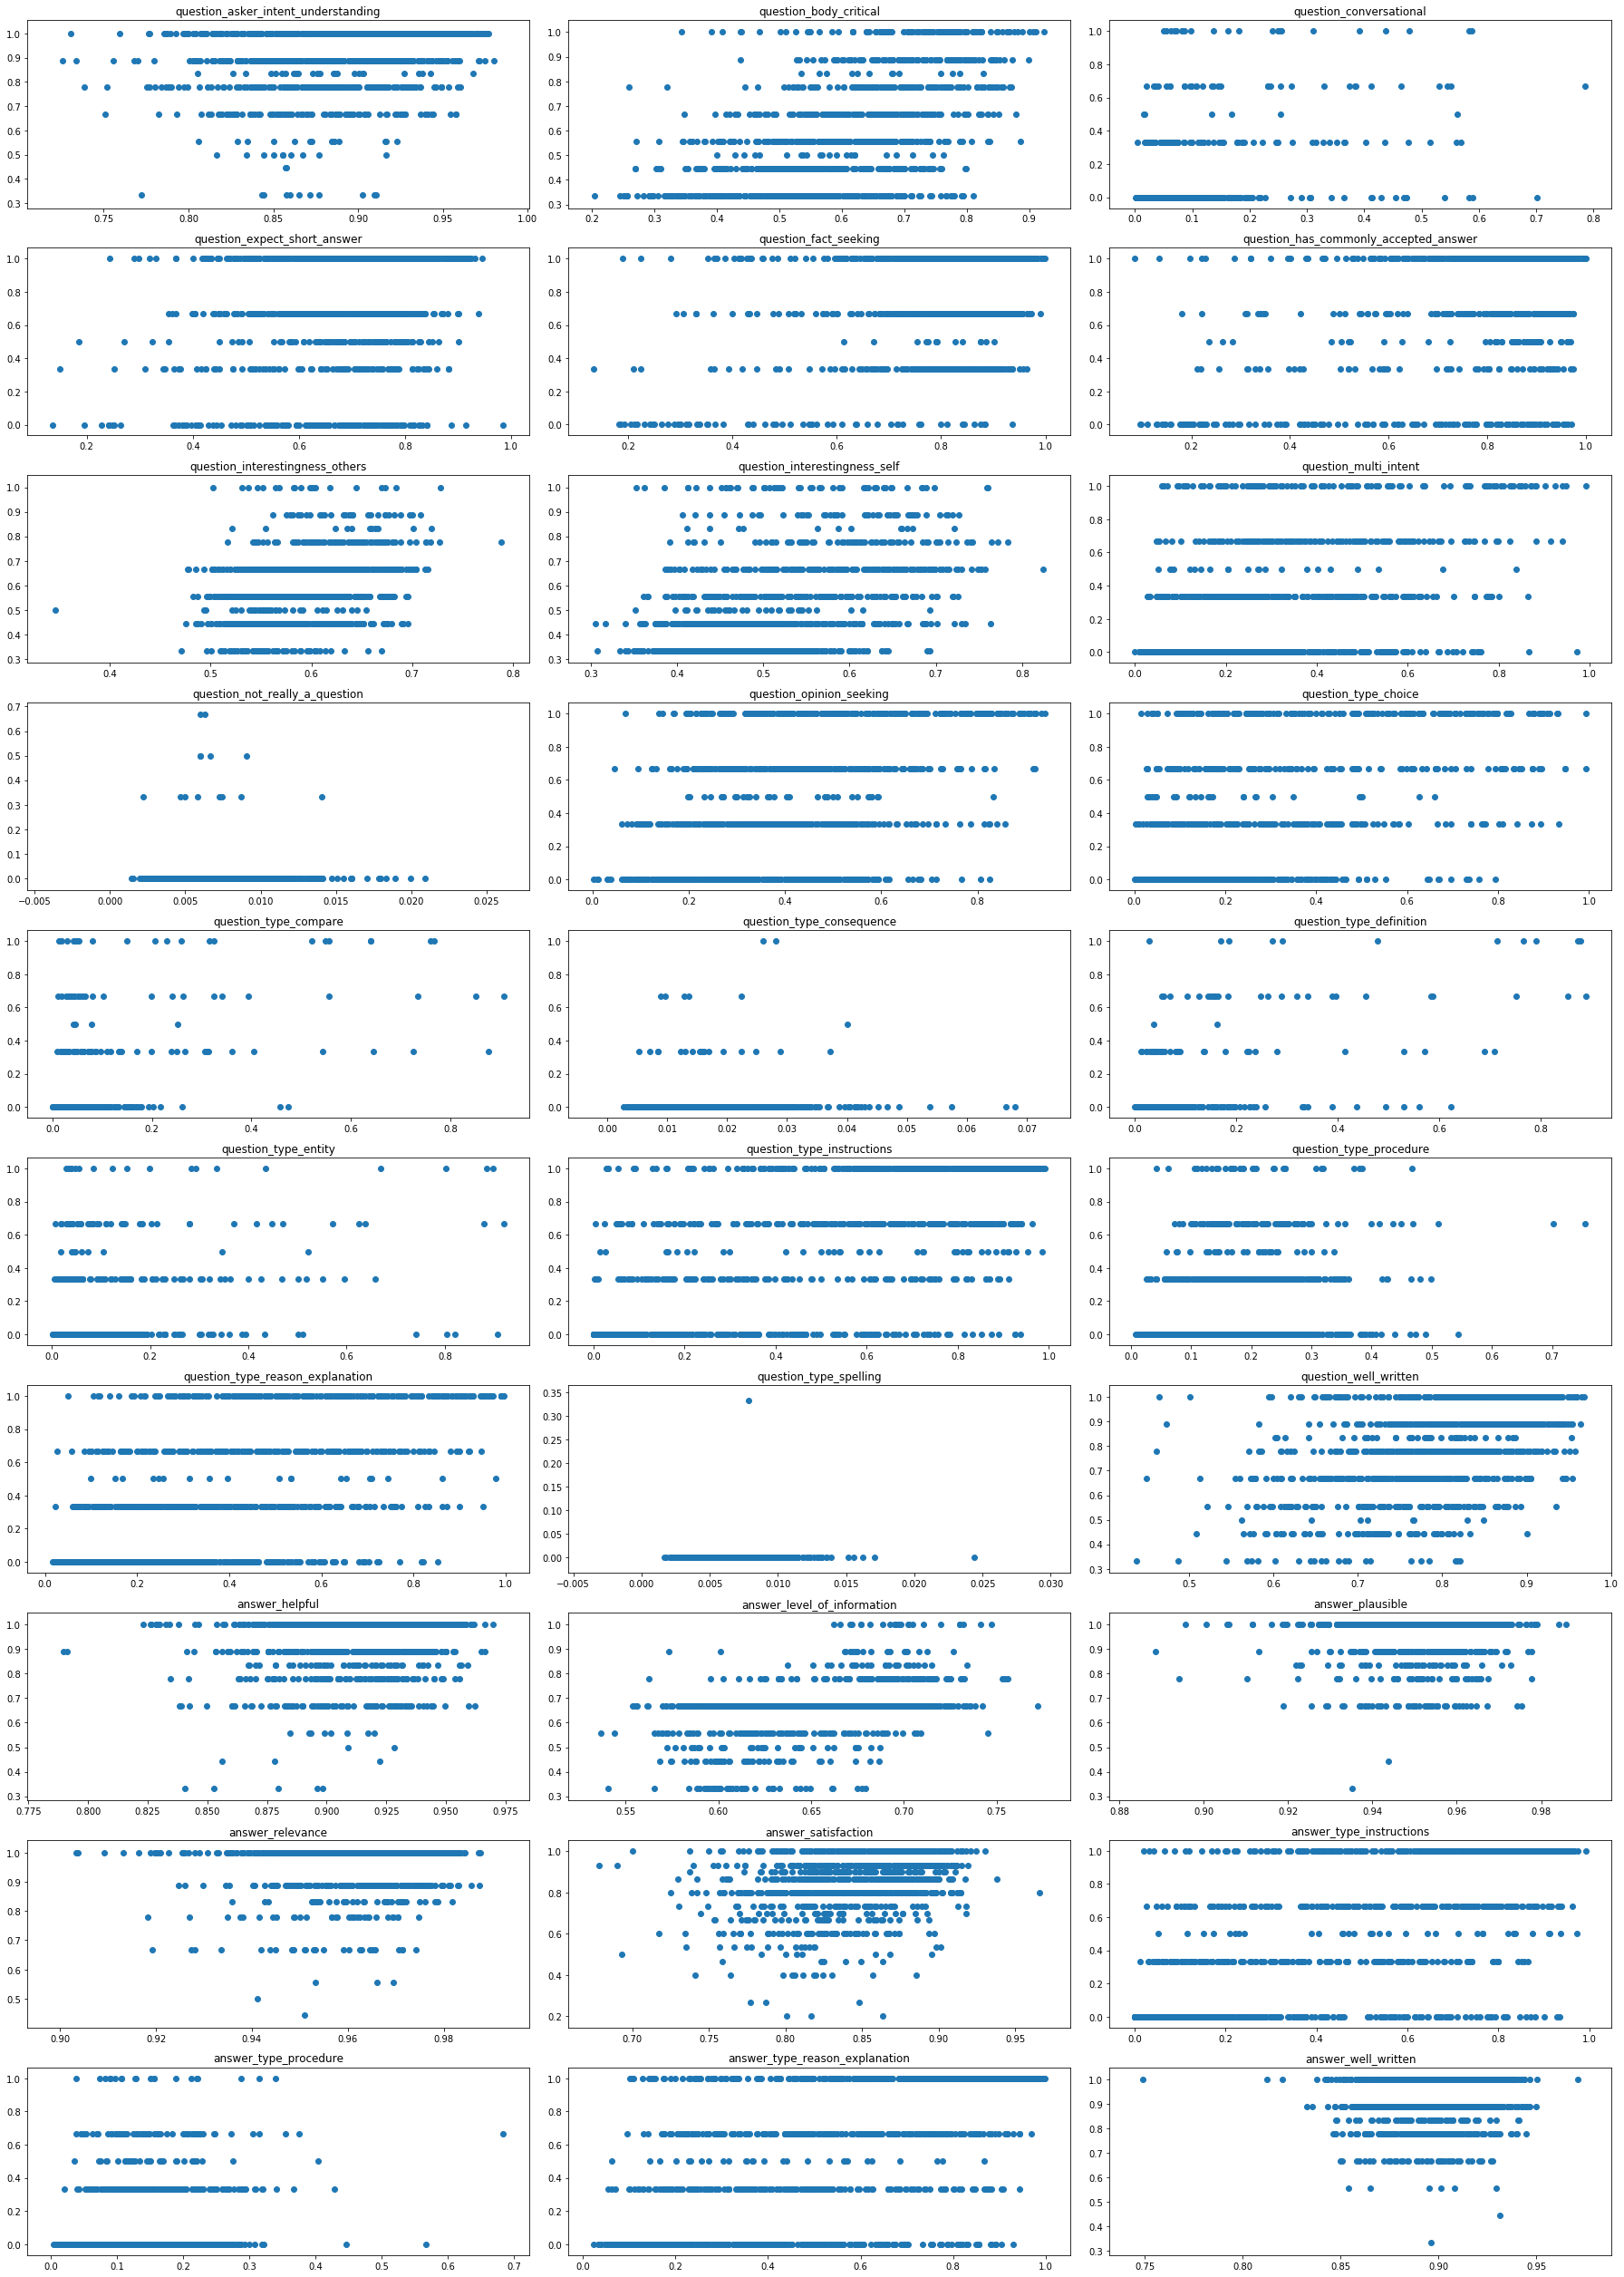

In [26]:
scatterplots(target_names, preds_test, y_test)

In [27]:
from lightgbm import LGBMRegressor

reg = LGBMRegressor(n_jobs=-1, min_child_samples=20)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse

scorer = make_scorer(mse, greater_is_better=False)

rs = RandomizedSearchCV(estimator=reg, 
                        param_distributions={'learning_rate':[0.1,0.05, 0.01, 0.005, 0.001],
                                                            'n_estimators':[100,500,1000],
                                                            'reg_alpha':[0,0.05,0.1,0.5,1,2,5,10,50],
                                                            'max_depth':[4,None]},
                       n_iter=10,
                       scoring=scorer,
                       n_jobs=-1,
                       refit=True, 
                        cv=5)

In [28]:
model2 = keras.models.Model(model.input, model.get_layer('last_batch_normalization').output)

In [29]:
X_train_rf = model2.predict([X_t_train, X_q_train, X_a_train])
X_test_rf = model2.predict([X_t_test, X_q_test, X_a_test])

In [30]:
preds_rf_train = []
preds_rf_test = []

for i in range(len(target_names)):
    
    y = y_train[:,i]
    
    rs.fit(X_train_rf, y)
    
    reg = rs.best_estimator_
    
    path = 'models/' + target_names[i] + '_model.pickle'
    with open(path, 'wb') as f:
        pickle.dump(reg, f)

    preds_rf_train.append(reg.predict(X_train_rf))
    preds_rf_test.append(reg.predict(X_test_rf))
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [31]:
preds_rf_train = np.array(preds_rf_train)
preds_rf_train = preds_rf_train.T

preds_rf_test = np.array(preds_rf_test)
preds_rf_test = preds_rf_test.T

In [32]:
print_cors_mse(target_names, preds_rf_test, y_test)

question_asker_intent_understanding:     cor: 0.261,    mse: 0.016
question_body_critical:                  cor: 0.615,    mse: 0.03
question_conversational:                 cor: 0.392,    mse: 0.026
question_expect_short_answer:            cor: 0.219,    mse: 0.121
question_fact_seeking:                   cor: 0.278,    mse: 0.077
question_has_commonly_accepted_answer:   cor: 0.326,    mse: 0.093
question_interestingness_others:         cor: 0.364,    mse: 0.017
question_interestingness_self:           cor: 0.422,    mse: 0.03
question_multi_intent:                   cor: 0.463,    mse: 0.09
question_not_really_a_question:          cor: 0.063,    mse: 0.002
question_opinion_seeking:                cor: 0.383,    mse: 0.119
question_type_choice:                    cor: 0.583,    mse: 0.09
question_type_compare:                   cor: 0.293,    mse: 0.022
question_type_consequence:               cor: 0.125,    mse: 0.005
question_type_definition:                cor: 0.311,    mse: 0.012

In [33]:
print_cors_mse(target_names, preds_rf_train, y_train)

question_asker_intent_understanding:     cor: 0.719,    mse: 0.009
question_body_critical:                  cor: 0.944,    mse: 0.005
question_conversational:                 cor: 0.519,    mse: 0.009
question_expect_short_answer:            cor: 0.664,    mse: 0.073
question_fact_seeking:                   cor: 0.645,    mse: 0.049
question_has_commonly_accepted_answer:   cor: 0.667,    mse: 0.045
question_interestingness_others:         cor: 0.711,    mse: 0.01
question_interestingness_self:           cor: 0.908,    mse: 0.006
question_multi_intent:                   cor: 0.885,    mse: 0.001
question_not_really_a_question:          cor: 0.173,    mse: 0.002
question_opinion_seeking:                cor: 0.826,    mse: 0.046
question_type_choice:                    cor: 0.848,    mse: 0.027
question_type_compare:                   cor: 0.432,    mse: 0.0
question_type_consequence:               cor: 0.251,    mse: 0.003
question_type_definition:                cor: 0.392,    mse: 0.00

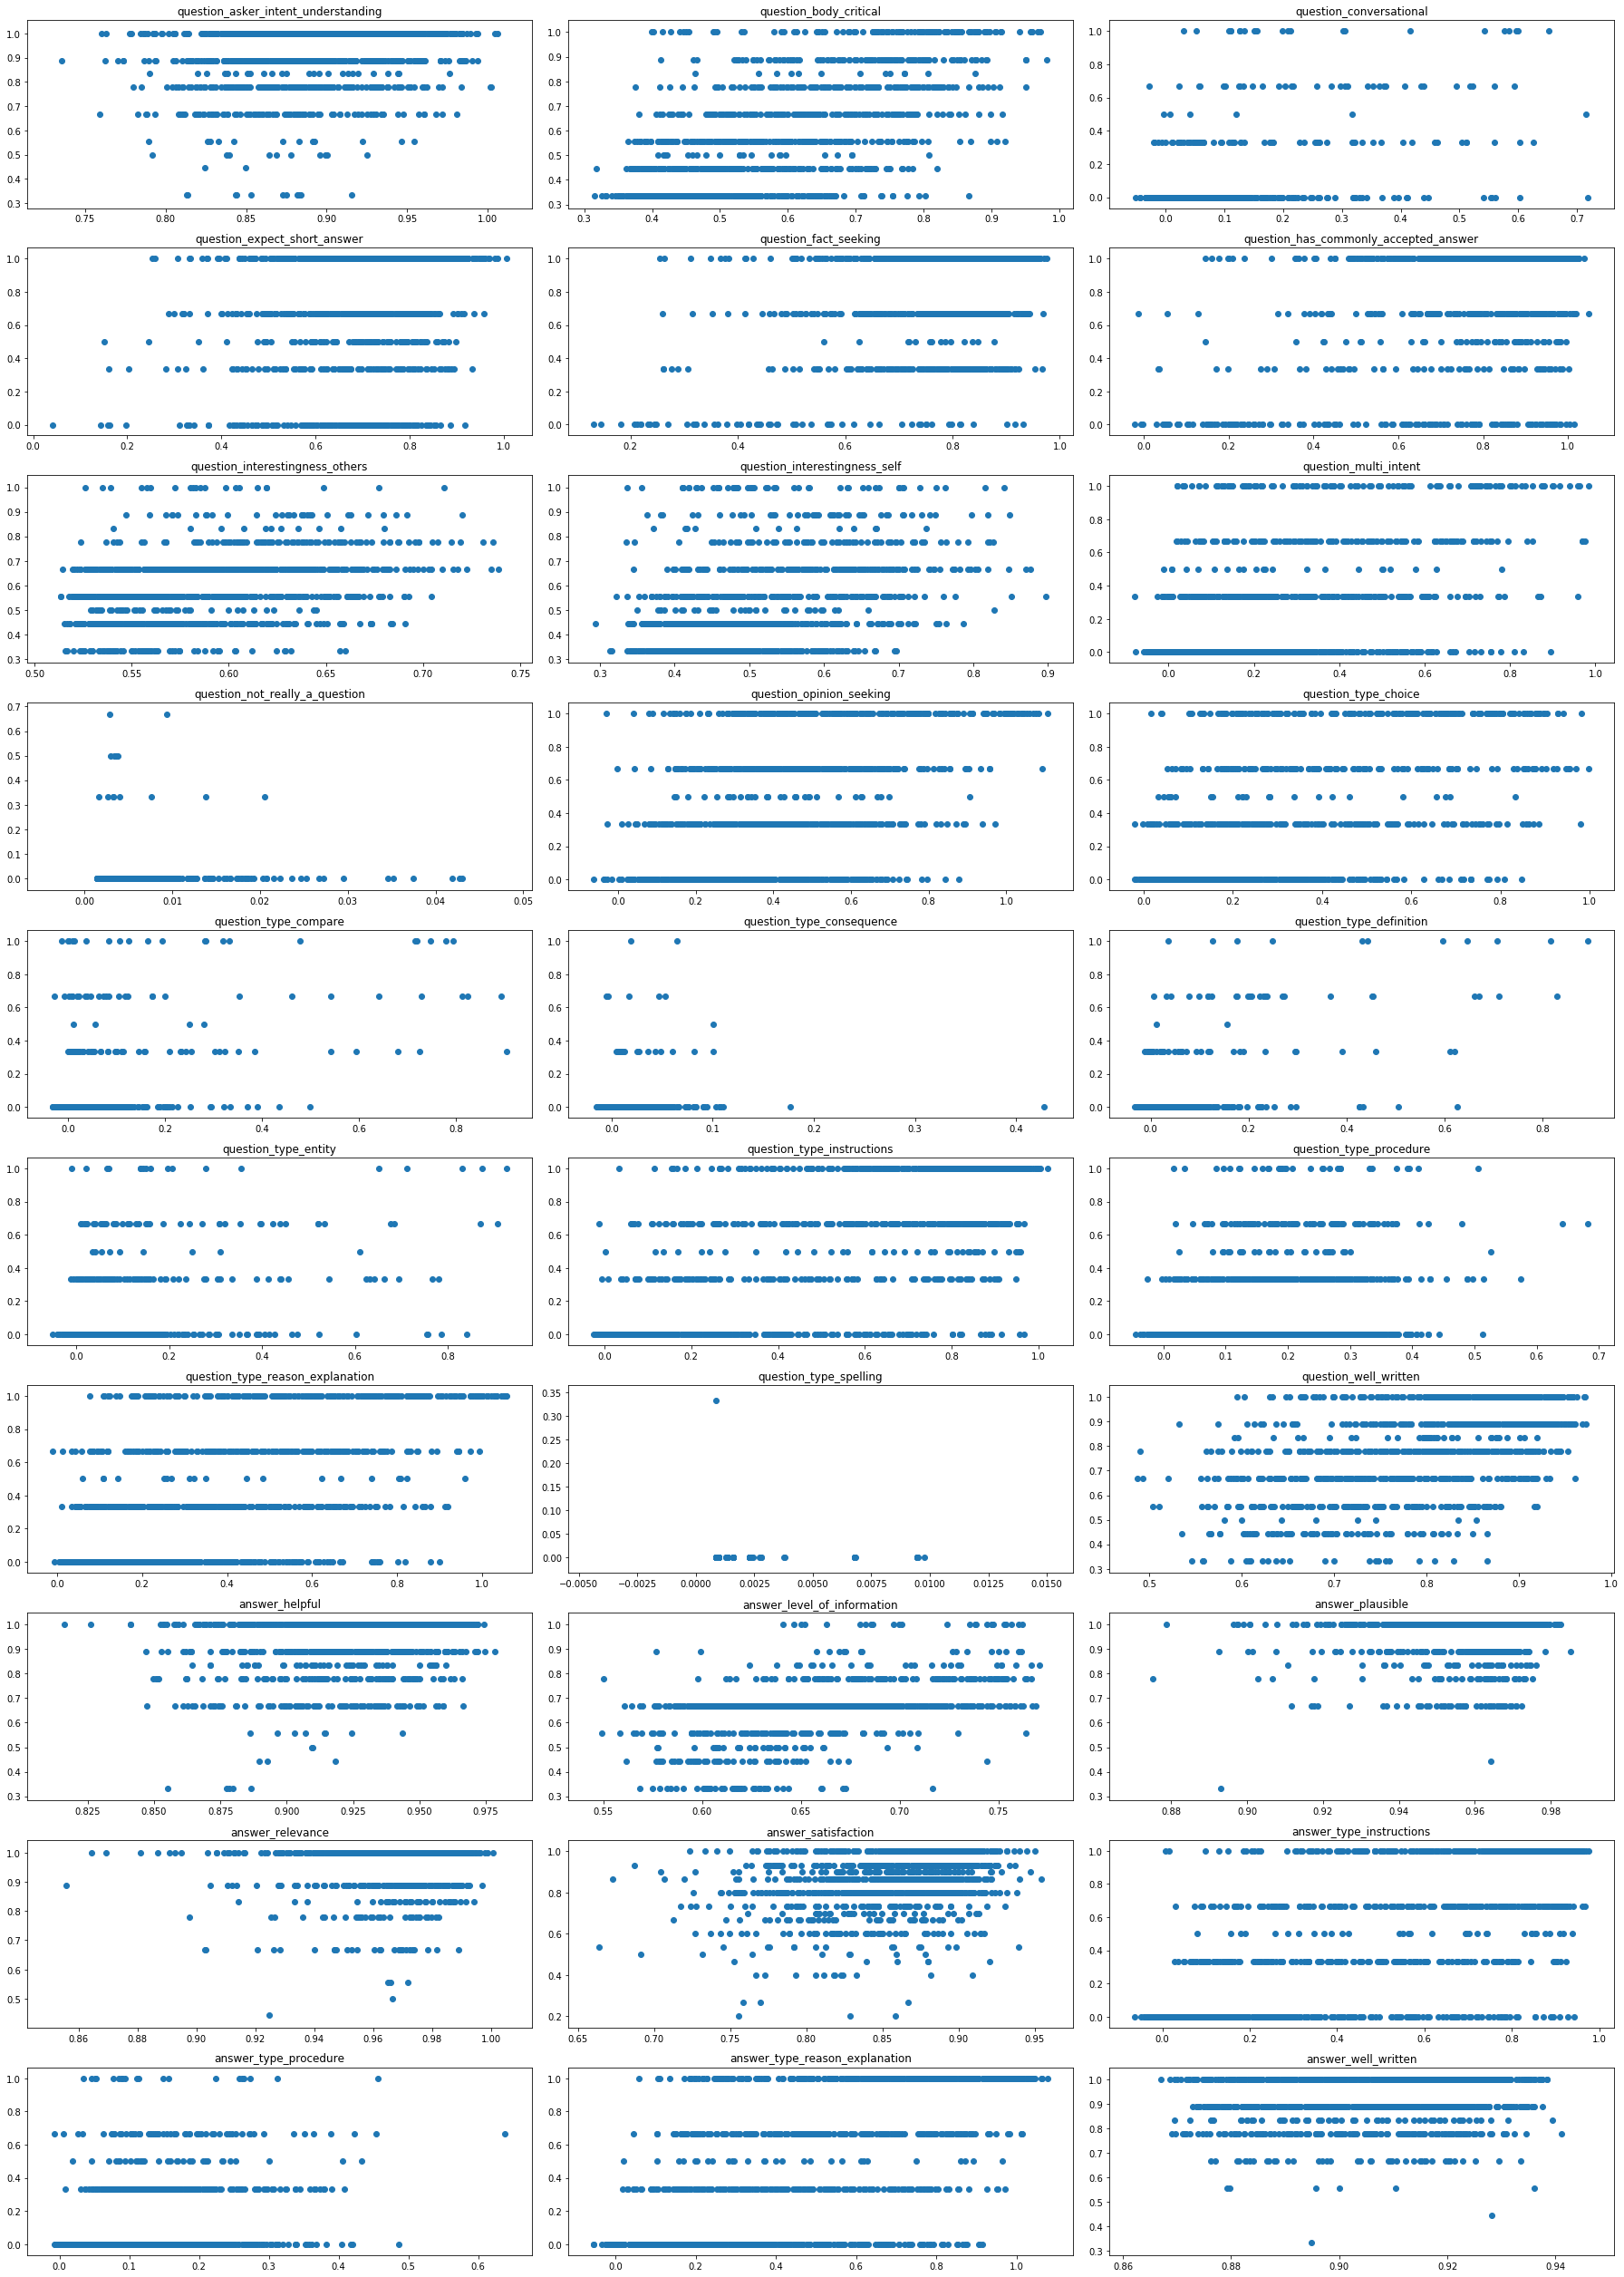

In [34]:
scatterplots(target_names, preds_rf_test, y_test)